<a href="https://colab.research.google.com/github/mitsu666/lightweightMMM_demo.0.1.6/blob/main/GoogleLightMMM_sample_data_0_1_6_ipynb_%E3%81%AE%E3%82%B3%E3%83%94%E3%83%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. 準備

## 0.0 Driveのマウント

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/MyDrive/003_Project/901_MMM(Stats)/google light MMM')
os.getcwd()

'/content/drive/MyDrive/003_Project/901_MMM(Stats)/google light MMM'

## 0.2 関係するライブラリのダウンロードとインストール

In [ ]:
# lightweight_mmmのインストール
!pip install lightweight_mmm==0.1.6 # 2023年1月追加

In [ ]:
!pip uninstall -y matplotlib
!pip install matplotlib==3.1.3

Found existing installation: matplotlib 3.3.4
Uninstalling matplotlib-3.3.4:
  Successfully uninstalled matplotlib-3.3.4
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 50.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lightweight-mmm 0.1.6 requires matplotlib==3.3.4, but you have matplotlib 3.1.3 which is incompatible.


In [ ]:
# import numpy as np
import jax.numpy as jnp
import numpyro 
import pandas as pd

In [ ]:
# Import the relevant modules of the library
from lightweight_mmm import lightweight_mmm
from lightweight_mmm import optimize_media
from lightweight_mmm import plot
from lightweight_mmm import preprocessing
from lightweight_mmm import utils

# seed値の設定
SEED = 1
N_CHAINS = 2
numpyro.set_host_device_count(N_CHAINS)

# 1. 実践

## 1.1 データ読み込み

In [ ]:
# rawデータ読み込み
df = pd.read_csv('data.csv')
print (df.head())

# 2020までを学習データにするためindex取得
print (df[df['Date']<='2020-12-31'].index.max())

         Date       TV    Radio  Banners    Sales
0  2018-01-07  13528.1     0.00     0.00  4779.80
1  2018-01-14      0.0  5349.65  2218.93  8405.72
2  2018-01-21      0.0  4235.86  2046.96  7353.87
3  2018-01-28      0.0  3562.21     0.00  4351.05
4  2018-02-04      0.0     0.00  2187.29  5472.92
155


In [ ]:
# メディア投下量
media_data = jnp.array(df.loc[:,['TV','Radio','Banners']])
# メディア以外の特徴量
# extra_features = jnp.array(df.loc[:,['平均気温','降水量','週末FLG']])
# 売上
target = jnp.array(df.loc[:,'Sales'])
# Total Cost  各メディアの投下金額 (DEMOの方がsimulated_dummy関数が上手く動いていないよう)
costs = media_data.sum(axis=0) # media_dataがimpの(imp / 1000) * CPMなどと変換

## 1.2 データ準備

In [ ]:
# 訓練検証に分ける 
split_point = 155 + 1 # 2020までを訓練データとする 分割部分のindexを与える
# Media data
media_data_train = media_data[:split_point, ...]
media_data_test = media_data[split_point:, ...]
# Extra features # 今回はその他変数なし
# extra_features_train = extra_features[:split_point, ...]
# extra_features_test = extra_features[split_point:, ...]
# Target
target_train = target[:split_point]
target_test = target[split_point:]

In [ ]:
# スケーリングする 平行移動ではなく、平均を1とする変換
media_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
# extra_features_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
target_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
cost_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)

media_data_train_scale = media_scaler.fit_transform(media_data_train)
# extra_features_train_scale = extra_features_scaler.fit_transform(extra_features_train)
target_train_scale = target_scaler.fit_transform(target_train)
costs_scale = cost_scaler.fit_transform(costs)

## 1.3 モデリング

In [ ]:
# modelのインスタンス化 メディアの減衰効果をcarryoverにする 
mmm = lightweight_mmm.LightweightMMM(model_name="carryover")

model_nameはhill_adstock/adstock/carryover から選択可能

In [ ]:
%%time
number_warmup=2000
number_samples=2000
# For replicability in terms of random number generation in sampling
# reuse the same seed for different trainings.
mmm.fit(
    media=media_data_train_scale,
    media_prior=costs_scale,
    target=target_train_scale,
    # extra_features=extra_features_train,
    number_warmup=number_warmup,
    number_samples=number_samples,
    number_chains=N_CHAINS,
    seasonality_frequency=52,# 日次データの場合365として以下の変数のコメントアウトをはずす
    # weekday_seasonality=True,
    seed=SEED)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

CPU times: user 6min 54s, sys: 655 ms, total: 6min 55s
Wall time: 4min 5s


## 1.4 モデリング結果可視化

In [ ]:
mmm.print_summary()


                                 mean       std    median      5.0%     95.0%     n_eff     r_hat
ad_effect_retention_rate[0]      0.70      0.12      0.73      0.53      0.89   2421.15      1.00
ad_effect_retention_rate[1]      0.18      0.19      0.12      0.00      0.44   1938.74      1.00
ad_effect_retention_rate[2]      0.26      0.22      0.20      0.00      0.59   3039.11      1.00
              coef_media[0]      0.23      0.04      0.22      0.15      0.29   2625.82      1.00
              coef_media[1]      0.07      0.03      0.07      0.03      0.12   1618.75      1.00
              coef_media[2]      0.17      0.05      0.17      0.10      0.24   2585.64      1.00
              coef_trend[0]      0.02      0.01      0.01      0.00      0.03   1106.67      1.00
                 expo_trend      0.92      0.12      0.91      0.71      1.11   1546.92      1.00
                exponent[0]      0.79      0.13      0.81      0.61      1.00   2822.11      1.00
                exp

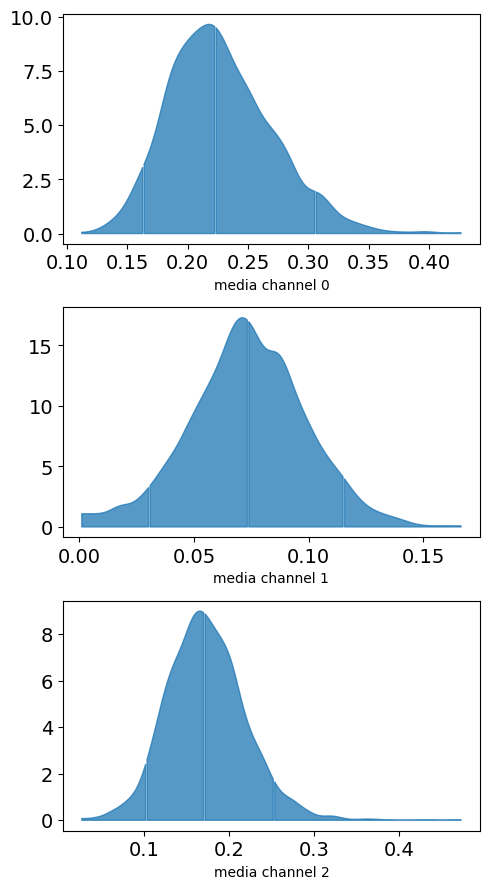

In [ ]:
plot.plot_media_channel_posteriors(media_mix_model=mmm)

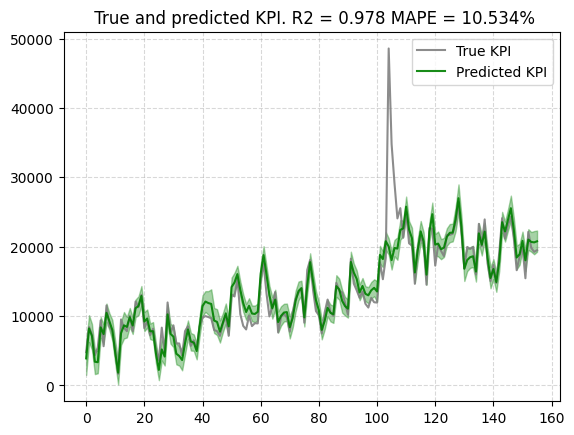

In [ ]:
# scaleある場合
plot.plot_model_fit(mmm, target_scaler=target_scaler)

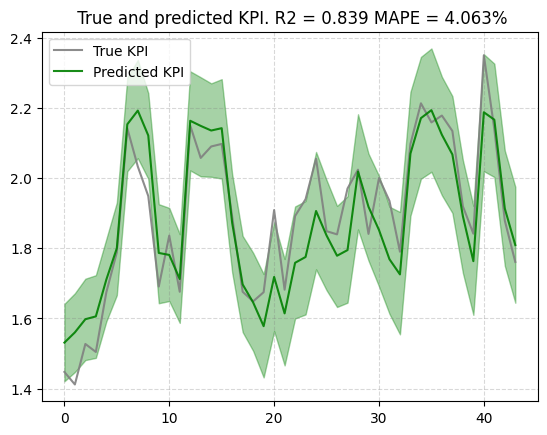

In [ ]:
# testデータに当てはめる
new_predictions = mmm.predict(media=media_scaler.transform(media_data_test),
                              # extra_features=extra_features_scaler.transform(extra_features_test),
                              seed=SEED)
# new_predictions.shape
# plotする
plot.plot_out_of_sample_model_fit(out_of_sample_predictions=new_predictions,
                                 out_of_sample_target=target_scaler.transform(target_test) )

In [ ]:
# 推定値などを出力
media_contribution, roi_hat = mmm.get_posterior_metrics(target_scaler=target_scaler, cost_scaler=cost_scaler)

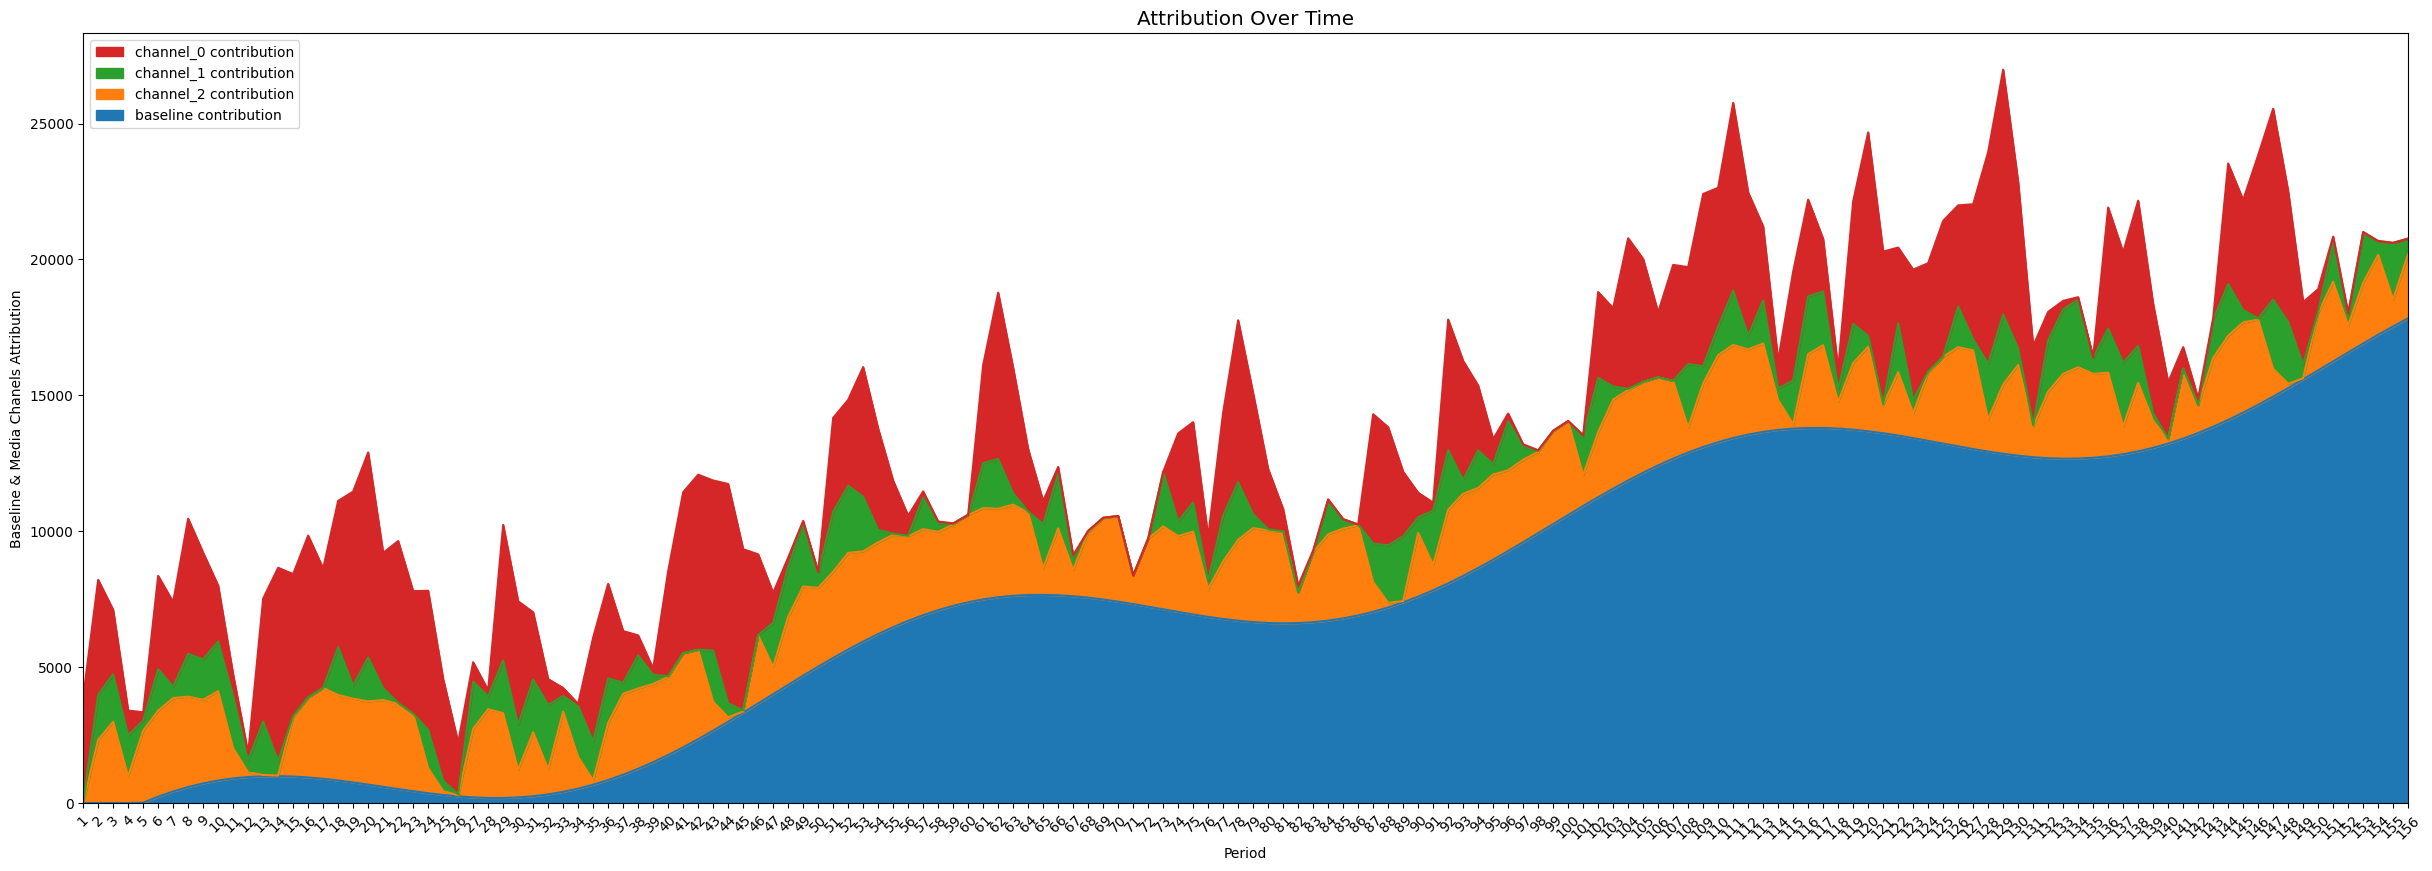

In [ ]:
plot.plot_media_baseline_contribution_area_plot(media_mix_model=mmm,
                                                target_scaler=target_scaler,
                                                fig_size=(30,10))

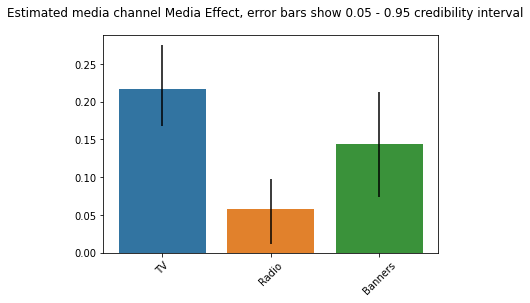

In [ ]:
# # メディア効果可視化
# plot.plot_bars_media_metrics(metric=media_effect, metric_name="Media Effect",channel_names=['TV','Radio','Banners'])

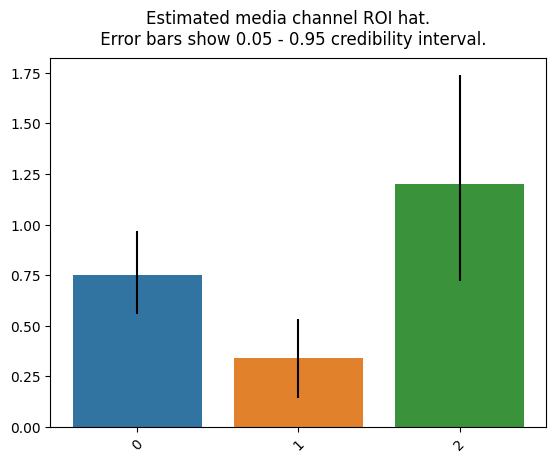

In [ ]:
# ROI可視化
plot.plot_bars_media_metrics(metric=roi_hat, metric_name="ROI hat")

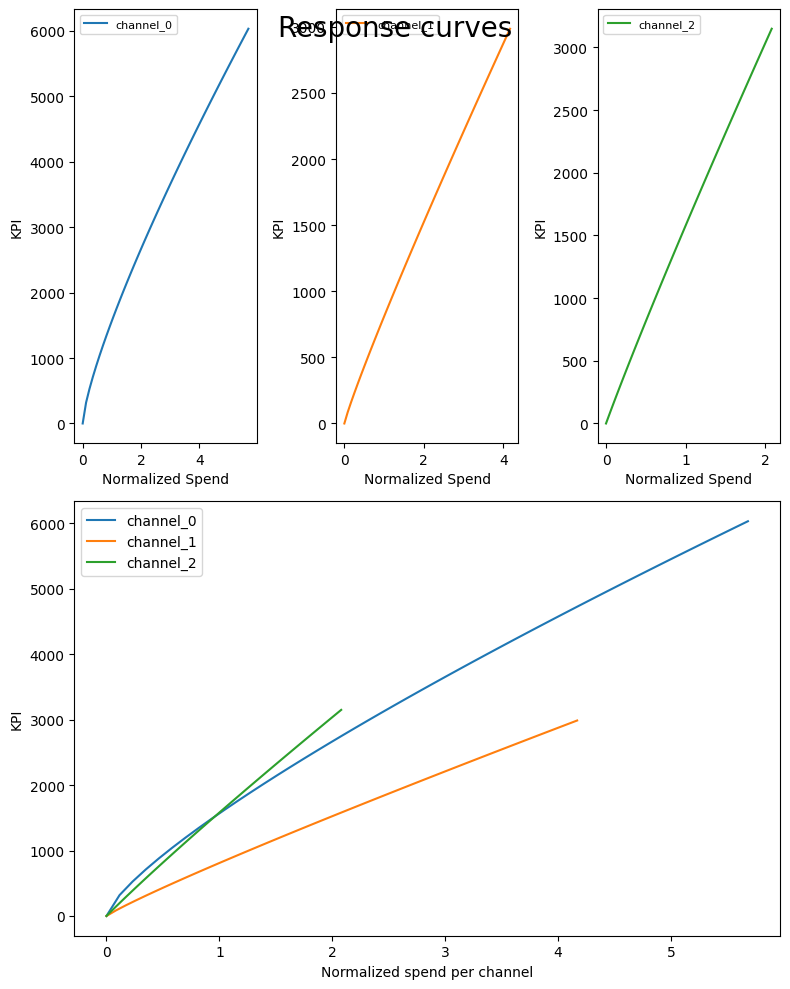

In [ ]:
# メディア投下量と売上の関係
plot.plot_response_curves(
    media_mix_model=mmm, target_scaler=target_scaler, seed=SEED)

## 1.5 予算の最適化

In [ ]:
# 成果変数の円/成果の単位を入力→売上円であるため、全部1でOK
prices = jnp.ones(mmm.n_media_channels)

In [ ]:
# 最適化したい期間
n_time_periods = media_data_test.shape[0]
print (n_time_periods)
# 予算の総量
budget = jnp.sum(media_data_train.mean(axis=0)) * n_time_periods
print (budget)

44
290177.5


In [ ]:
# Run optimization with the parameters of choice.
solution, kpi_without_optim, previous_media_allocation = optimize_media.find_optimal_budgets(
    n_time_periods=n_time_periods,
    media_mix_model=mmm,
    # extra_features=extra_features_scaler.transform(extra_features_test)[:n_time_periods],
    budget=budget,
    prices=prices,
    media_scaler=media_scaler,
    target_scaler=target_scaler,
    seed=SEED)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1148808.6016329345
            Iterations: 19
            Function evaluations: 126
            Gradient evaluations: 18


In [ ]:
# Obtain the optimal weekly allocation.
optimal_buget_allocation = prices * solution.x
optimal_buget_allocation

Array([136005.11,  77988.44,  76183.96], dtype=float32)

In [ ]:
# similar renormalization to get previous budget allocation
previous_budget_allocation = prices * previous_media_allocation
previous_budget_allocation

Array([129205.305,  97485.555,  63486.633], dtype=float32)

In [ ]:
# Both these values should be very close in order to compare KPI
budget, optimal_buget_allocation.sum()

(Array(290177.5, dtype=float32), Array(290177.5, dtype=float32))

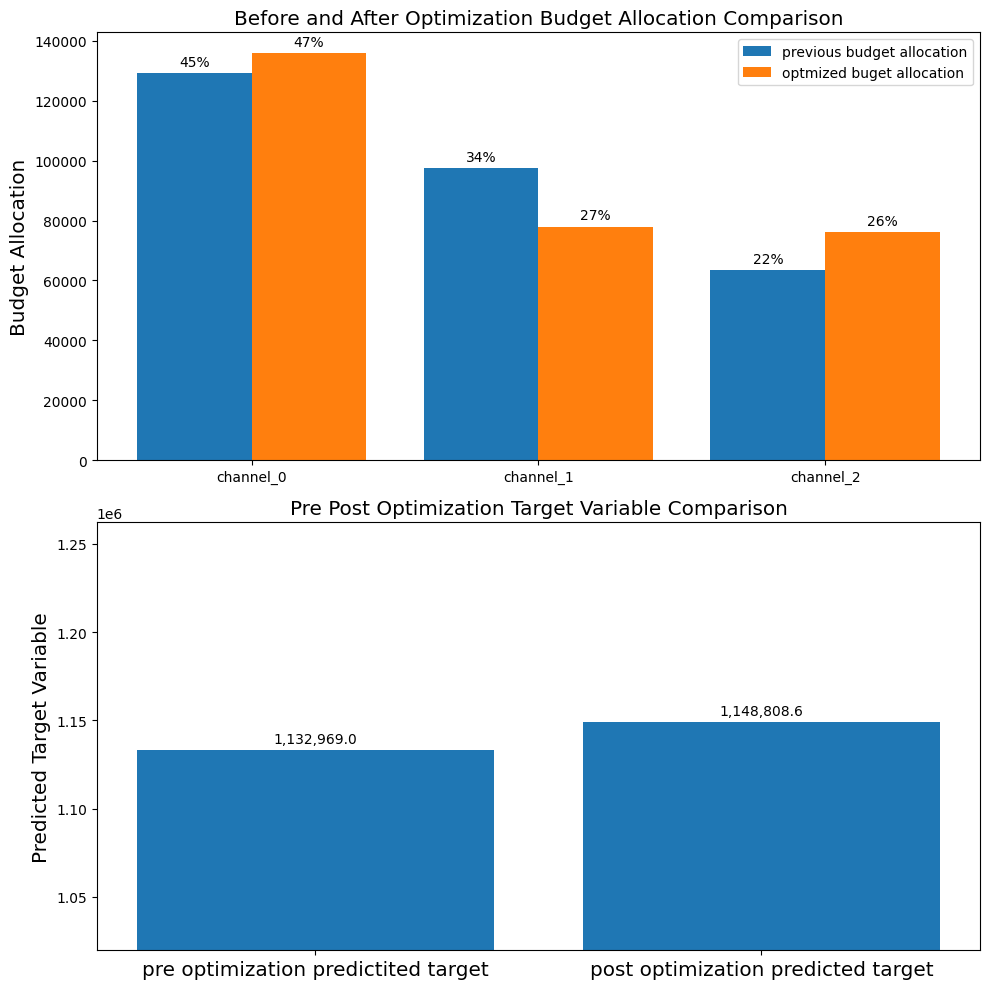

In [ ]:
# Plot out pre post optimization budget allocation and predicted target variable comparison.
plot.plot_pre_post_budget_allocation_comparison(media_mix_model=mmm, 
                                                kpi_with_optim=solution['fun'], 
                                                kpi_without_optim=kpi_without_optim,
                                                optimal_buget_allocation=optimal_buget_allocation, 
                                                previous_budget_allocation=previous_budget_allocation, 
                                                figure_size=(10,10))

In [ ]:
1148808.6 / 290177.5

3.9589857931783135

In [ ]:
target_test.sum() / c

Array(3.7449563, dtype=float32)

In [ ]:
1132969.0 / 290177.5

3.9043998931688364

In [ ]:
previous_media_allocation / 44

Array([2936.4841, 2215.5808, 1442.878 ], dtype=float32)

In [ ]:
 media_data_train.mean(axis=0)

Array([2936.4841, 2215.5806, 1442.878 ], dtype=float32)

In [ ]:
temp = pd.DataFrame(media_data_train)

In [ ]:
temp[temp>0].mean(axis=0).sum()*44

747558.1882192461

In [ ]:
temp[temp>0].mean(axis=0) / temp[temp>0].mean(axis=0).sum()

0    0.599166
1    0.282545
2    0.118289
dtype: float64